This code creates reflectivity Contoured Frequency by Altitude Diagrams (CFADs), which are essentially 2-D histograms that show how frequently different reflectivity bins occur within a given height range. This give a concise picture of the reflectivity distribution and how it varies with height. This code defines a function that calculates four types of CFADs. One type of CFAD shows the raw number of radar observations in each reflectivity, height bin. Another type of CFAD normalizes that CFAD based on the maximum number of radar observations in any one reflectivity, height bin. One type of CFAD normalizes each height level by the maximum number of radar observations in one of the reflectivity, height bins within that level. Finally, another type of CFAD normalizes each height level by the total number of radar observations present at that height level. 

In this project we were interested in comparing the reflectivity CFADs of three time periods that differed in terms of how polluted the environment was. Those time periods were already defined in an early code. Additionally, the radar data itself was already clean and quality controlled in another code. Finally, in previous code we ran the Python FLEXible object TRacKeR (PyFLEXTRKR, https://github.com/FlexTRKR/PyFLEXTRKR), algorithim to track convection. We are only interested in analyzing the reflectivity associated with cells that were tracked by that algorithim. Thus, prior to creating the CFADs, this code isolates only the cells that were tracked. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pyart
import netCDF4 as nc4
import glob
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from global_land_mask import globe
import time


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Set directory, field campaign, and filename

SaveName = 'TRACER'
PyFLEXDirectory = '/Local/Directory/Track/Arrays/'
RadarDirectory = '/Local/Radar/Directory/'
TrackDirectory = '/Local/Track/Directory/'

PlotDirectory = '/Local/Plot/Directory/'

SetHour = 0.5

Categories = ['Low', 'Moderate', 'High']


In [3]:
# Set bin intervals

AltitudeBins = np.arange(0, 15500, 500)
ReflectivityBins = np.arange(10, 66, 2)

FreqThreshold = 0.1


In [4]:
# Create colormap

cmap_raw = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray", "aliceblue", "powderblue", "skyblue", 
                                                                    "cornflowerblue", "royalblue", "steelblue",
                                                                    "cadetblue", "mediumseagreen", 
                                                                    "forestgreen", "olivedrab", "goldenrod", 
                                                                    "gold", "orange", "coral", "orangered",  
                                                                    "red", "crimson", "mediumvioletred", 
                                                                    "darkorchid", "rebeccapurple", "indigo", 
                                                                    "black"])

cmap_diff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["indigo","darkblue","mediumblue","blue","royalblue",
                                                                     "dodgerblue","deepskyblue","lightskyblue","skyblue",
                                                                     "powderblue","lightblue","lightcyan","white",
                                                                     "mistyrose","pink","lightcoral","salmon","coral","tomato",
                                                                     "orangered","red","crimson","firebrick","brown","darkred"])


In [5]:
# Define function to calculate CFADS

# method options: TotalAltitude, MaxAltitude, MaxTotal

def createCFAD(HeightArray, ReflectivityArray, HeightBins, ReflectivityBins, FreqThreshold, Method='TotalAltitude'):
    # Raw counts
    Size = np.array(np.shape(ReflectivityArray))
    if Size.size > 1:
        Counts, AltitudeEdges, ReflectivityEdges = np.histogram2d(np.reshape(HeightArray, Size[0]*Size[1]*Size[2]*Size[3]), 
                                                                  np.reshape(ReflectivityArray, Size[0]*Size[1]*Size[2]*Size[3]), 
                                                                 bins=[HeightBins, ReflectivityBins])  
    elif Size.size == 1:
        Counts, AltitudeEdges, ReflectivityEdges = np.histogram2d(HeightArray, ReflectivityArray, bins=[HeightBins, ReflectivityBins]) 

    if Method == 'TotalAltitude':
        # sum counts along height bins
        TotalCounts = np.sum(Counts, axis=1)
        
        # get threshold for normalizing (10% of total for each height)
        CountThreshold = FreqThreshold * np.max(TotalCounts)
        
        # repeat to create array same size as freq
        TotalCountsArray = np.repeat(TotalCounts[..., np.newaxis], Counts.shape[1], axis=1)
        
        # normalize
        Normalized = Counts / TotalCountsArray
        
    elif Method == 'MaxAltitude':
        # max along height bins
        TotalCounts = np.sum(Counts, axis=1)
        MaxCounts = np.nanmax(Counts, axis=1)
        
        # get threshold for normalizing (10% of total for each height)
        CountThreshold = FreqThreshold * np.max(TotalCounts)
        
        # repeat to create array same size as freq
        MaxCountsArray = np.repeat(MaxCounts[..., np.newaxis], Counts.shape[1], axis=1)
        TotalCountsArray = np.repeat(TotalCounts[..., np.newaxis], Counts.shape[1], axis=1)
        
        # normalize
        Normalized = Counts / MaxCountsArray
        
    elif Method == 'MaxTotal':
        # max along height bins
        TotalCounts = np.sum(Counts, axis=1)
        MaxCounts = np.nanmax(Counts)
        
        # get threshold for normalizing (10% of total for each height)
        CountThreshold = FreqThreshold * np.max(TotalCounts)
        
        # repeat to create array same size as freq
        MaxCountsArray = np.ones_like(Counts) * MaxCounts
        TotalCountsArray = np.repeat(TotalCounts[..., np.newaxis], Counts.shape[1], axis=1)
        
        # normalize
        Normalized = Counts / MaxCountsArray
    
    # mask data where there is not enough points
    MaskNormalized = np.copy(Normalized)
    MaskNormalized[TotalCountsArray < CountThreshold] = np.nan

    Counts[Counts == 0] = np.nan
    Normalized[Normalized == 0] = np.nan
    MaskNormalized[MaskNormalized == 0] = np.nan

    return Counts, Normalized, MaskNormalized
    

In [6]:
# Create aerosol category CFADs

CFAD_CountsA_nTA = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan
CFAD_NormalizedA_nTA = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan
CFAD_MaskNormalizedA_nTA = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan

CFAD_CountsA_nMA = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan
CFAD_NormalizedA_nMA = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan
CFAD_MaskNormalizedA_nMA = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan

CFAD_CountsA_nMT = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan
CFAD_NormalizedA_nMT = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan
CFAD_MaskNormalizedA_nMT = np.empty((3, len(AltitudeBins)-1, len(ReflectivityBins)-1), dtype=float)*np.nan

for a in range(0, 3):
    print(Categories[a])
    
    # Load file list)
    Data = nc4.Dataset(TrackDirectory + SaveName + '_Track_Time-Number.nc', 'r')
    if a == 0:
        RawTimes = np.array(Data.variables['C1Low_DateTime'])
        CloudNumber = np.array(Data.variables['C1Low_CloudNumber'])
    elif a == 1:
        RawTimes = np.array(Data.variables['C1Mod_DateTime'])
        CloudNumber = np.array(Data.variables['C1Mod_CloudNumber'])
    elif a == 2:
        RawTimes = np.array(Data.variables['C1High_DateTime'])
        CloudNumber = np.array(Data.variables['C1High_CloudNumber'])
    Data.close()

    # Convert times
    DateTimes = []
    Test = []
    for i in range(0, len(RawTimes)):
        DateTimes = np.append(DateTimes, datetime(1970, 1, 1, 0, 0, 0) + timedelta(seconds = int(RawTimes[i])))

    # Load data        
    Altitude_R = [] 
    DBZ = [] 

    nFiles = len(DateTimes)
    print(nFiles)
    for f in range(0, nFiles):
        String = str(DateTimes[f])
        
        YearString = str(String[0:4])
        MonthString = str(String[5:7])
        DayString = str(String[8:10])
        HourString = str(String[11:13])
        MinuteString = str(String[14:16])
        TimeString = YearString + MonthString + DayString + '_' + HourString + MinuteString

        # PyFLEXTRKR
        Files = glob.glob(PyFLEXDirectory + 'celltracks_' + TimeString[0:-2] + '*')
        
        nFiles = len(Files)
        File_Times = []
        for t in range(0, nFiles):
            File_Times = np.append(File_Times, datetime(int(str(Files[t])[-18:-14]), int(str(Files[t][-14:-12])), 
                                                                int(str(Files[t])[-12:-10]), int(str(Files[t][-9:-7])),
                                                                int(str(Files[t])[-7:-5]), int(str(Files[t][-5:-3]))))
        Index = np.nanargmin(np.absolute(np.subtract(File_Times, DateTimes[f])))
        
        PyFlexFile = glob.glob(Files[Index])

        if len(PyFlexFile) == 1:
            PyFlexFile = PyFlexFile[0]
        else:
            print(PyFLEXDirectory + 'celltracks_' + TimeString + '*')
            print(DateTimes[f])
            print(TimeString)
            continue

        # Load convective mask data
        Data = nc4.Dataset(PyFlexFile, 'r')
        if f == 0:
            xDistance_PyF = np.array(Data.variables['x'])[:]
            yDistance_PyF = np.array(Data.variables['y'])[:]
            Latitude_PyF = np.array(Data.variables['latitude'])[:]
            Longitude_PyF = np.array(Data.variables['longitude'])[:]
        ConvMask = np.squeeze(np.array(Data.variables['feature_number']))[:, :]
        Data.close()

        # Grid convective mask
        ConvMaskArray = np.empty((30, 121, 121), dtype=float)*np.nan
        for l in range(0, 30):
            ConvMaskArray[l, :, :] = np.copy(ConvMask)
        
        # Load radar data 
        Files = glob.glob(RadarDirectory + 'KHGX_DBZgrid_2022-' + MonthString + '-' + DayString + '_' + 
                           HourString + ':*')
    
        nFiles = len(Files)
        File_Times = []
        for t in range(0, nFiles):
            File_Times = np.append(File_Times, datetime(int(str(Files[t])[-22:-18]), int(str(Files[t][-17:-15])), 
                                                                int(str(Files[t])[-14:-12]), int(str(Files[t][-11:-9])),
                                                                int(str(Files[t])[-8:-6]), int(str(Files[t][-5:-3]))))
        Index = np.nanargmin(np.absolute(np.subtract(File_Times, DateTimes[f])))
    
        FileString = glob.glob(Files[Index])[0]
        Data = nc4.Dataset(FileString, 'r')
            
        if f == 0:
            xDistance_R = np.array(Data.variables['x'])[:]
            yDistance_R = np.array(Data.variables['y'])[:]
        Latitude_R = np.array(Data.variables['point_latitude'])[:, :]
        Longitude_R = np.array(Data.variables['point_longitude'])[:, :]
        tAlt = np.array(Data.variables['point_altitude'])[0:30, :, :]
        tDBZ = np.squeeze(np.array(Data.variables['DBZ'])[:, 0:30, :, :])
        Data.close()
        
        # Isolate convection
        Conv = np.squeeze(np.array(np.where(((ConvMaskArray == CloudNumber[f]) & (tDBZ > 10)))))
        
        if np.array(np.shape(Conv)).size > 1:  
            Altitude_R = np.append(Altitude_R, tAlt[Conv[0, :], Conv[1, :], Conv[2, :]])
            DBZ = np.append(DBZ, tDBZ[Conv[0, :], Conv[1, :], Conv[2, :]])

    CFAD_CountsA_nTA[a, :, :], CFAD_NormalizedA_nTA[a, :, :], CFAD_MaskNormalizedA_nTA[a, :, :] = createCFAD(Altitude_R, 
                                                                                                                            DBZ, 
                                                                                                                            AltitudeBins, 
                                                                                                                            ReflectivityBins,
                                                                                                                            FreqThreshold, 
                                                                                                                            Method='TotalAltitude')
    CFAD_CountsA_nMA[a, :, :], CFAD_NormalizedA_nMA[a, :, :], CFAD_MaskNormalizedA_nMA[a, :, :] = createCFAD(Altitude_R, 
                                                                                                                            DBZ, AltitudeBins, 
                                                                                                                            ReflectivityBins, 
                                                                                                                            FreqThreshold, 
                                                                                                                            Method='MaxAltitude')
    CFAD_CountsA_nMT[a, :, :], CFAD_NormalizedA_nMT[a, :, :], CFAD_MaskNormalizedA_nMT[a, :, :] = createCFAD(Altitude_R, 
                                                                                                                            DBZ, 
                                                                                                                            AltitudeBins, 
                                                                                                                            ReflectivityBins, 
                                                                                                                            FreqThreshold, 
                                                                                                                            Method='MaxTotal')

    del DBZ, Altitude_R
    

Low
355
Moderate
396
High
786


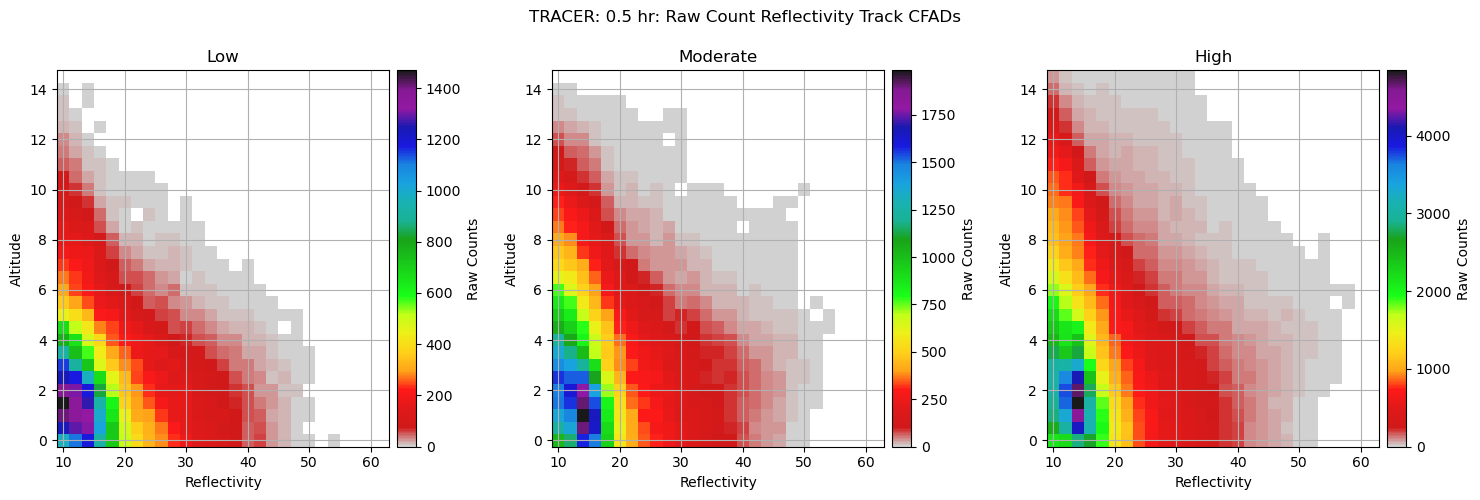

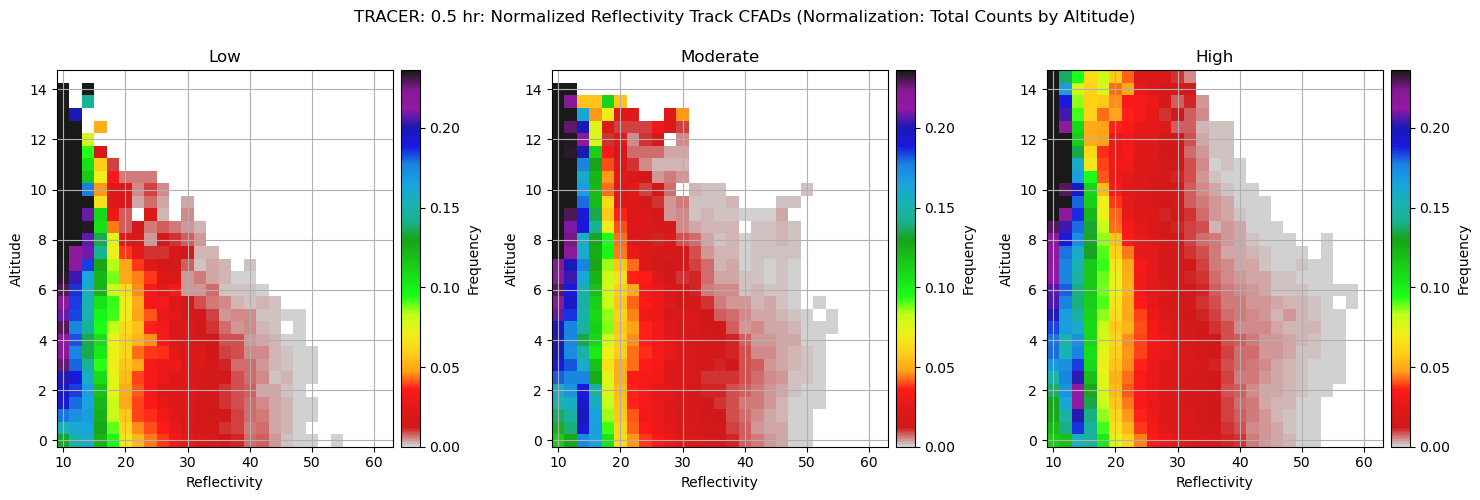

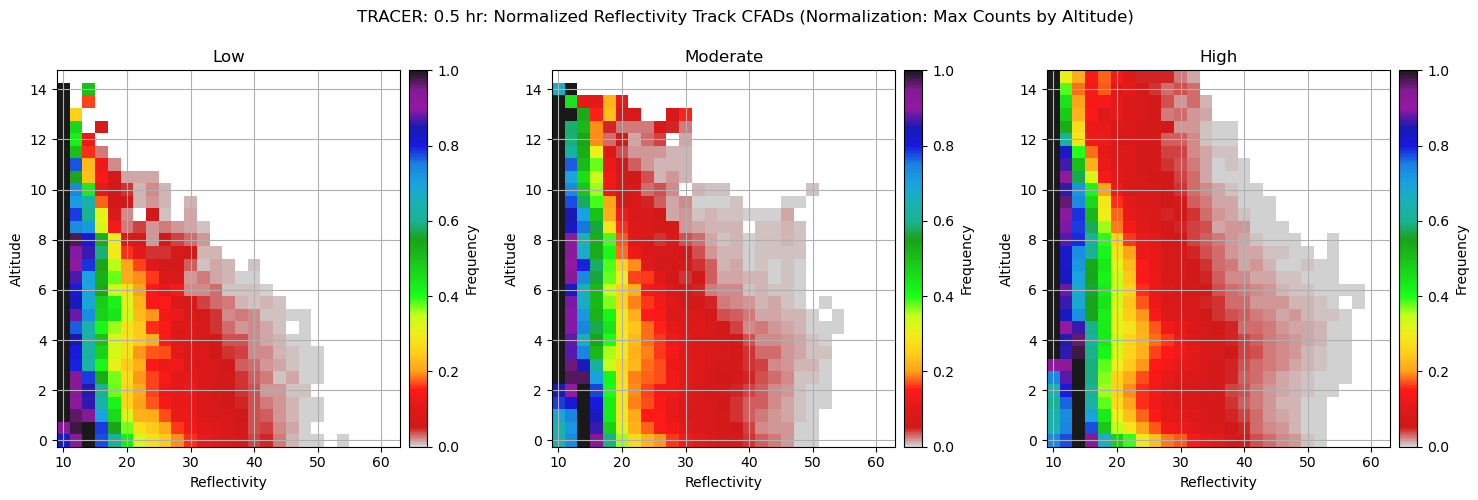

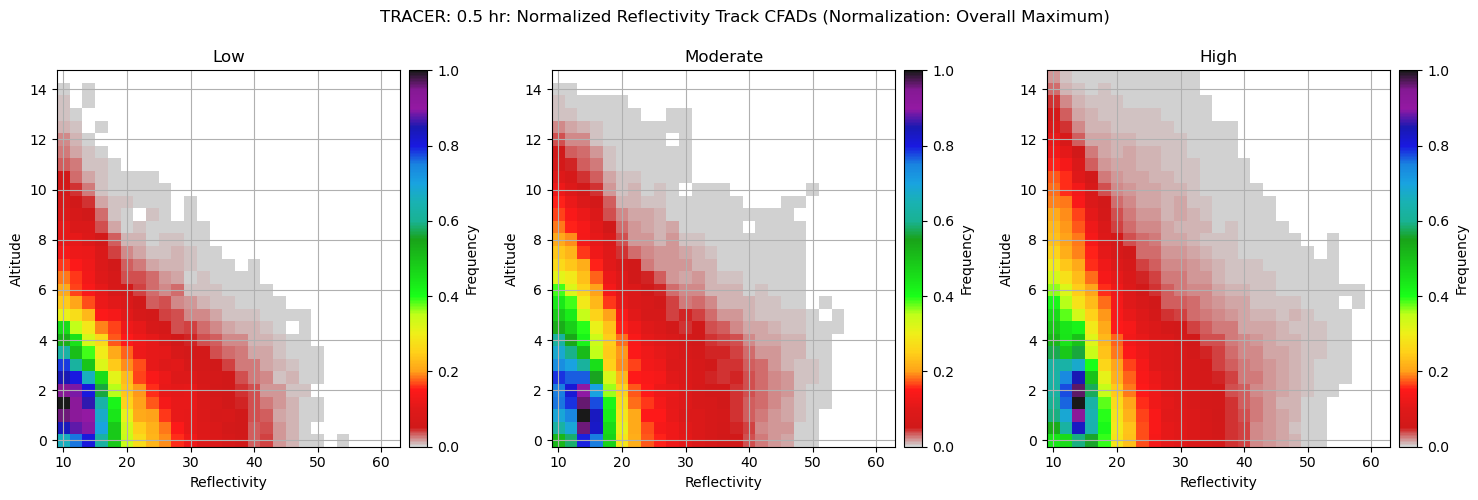

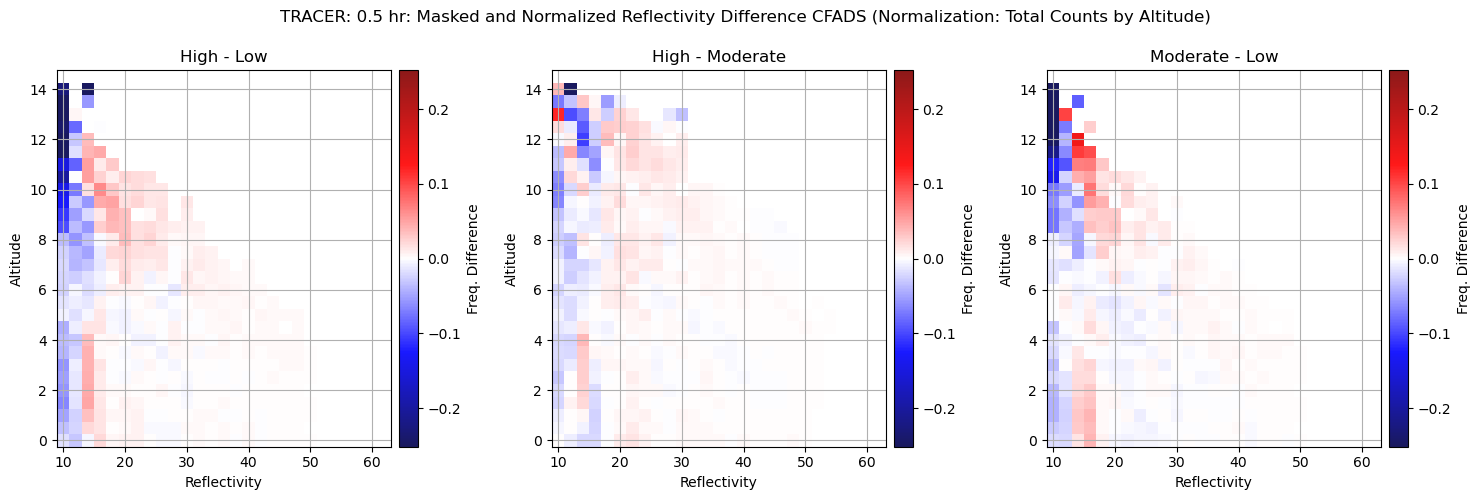

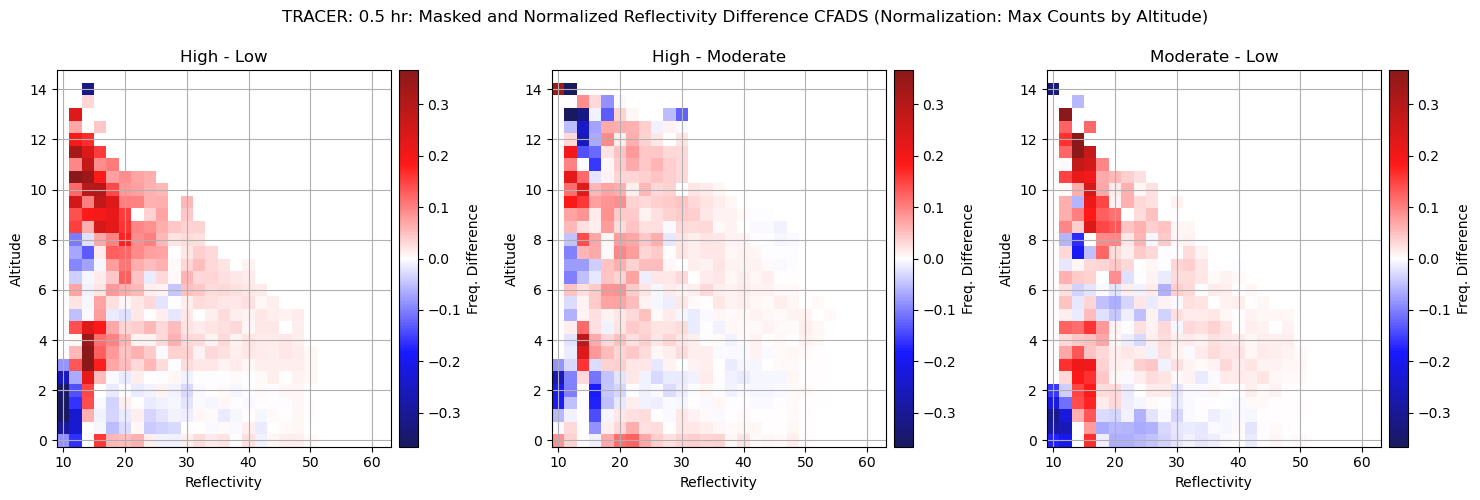

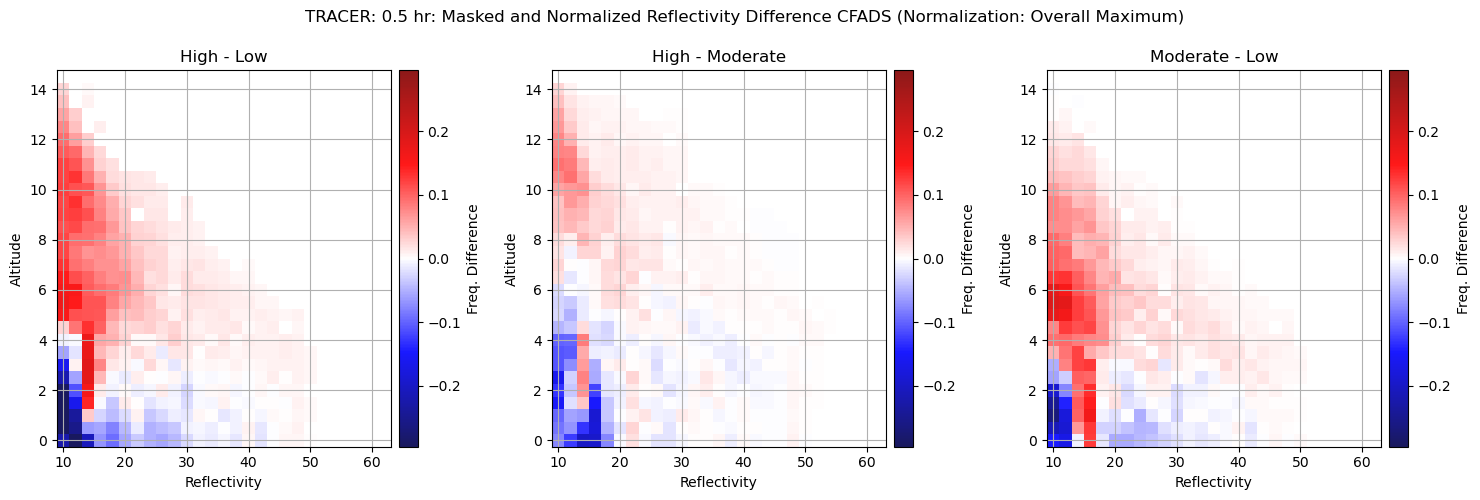

In [12]:
# Plot aersol category CFADs

xGrid, yGrid = np.meshgrid(ReflectivityBins[0:-1], AltitudeBins[0:-1]/1000)

# Raw Counts
fig = plt.figure(figsize=(15, 5))
fig.suptitle(SaveName + ': ' + str(SetHour) + ' hr: Raw Count Reflectivity Track CFADs', y=0.99)
ColorMax = np.nanpercentile(CFAD_CountsA_nTA[:, :, :], 99.5)

for a in range(0, 3):
    ax = plt.subplot(1, 3, a+1)   
    ax.set_title(Categories[a])

    #C = ax.pcolormesh(xGrid, yGrid, CFAD_CountsA_nTA[a, :, :], vmin=0, vmax=ColorMax, alpha=0.9, cmap='nipy_spectral_r') #cmap=cmap_raw)
    C = ax.pcolormesh(xGrid, yGrid, CFAD_CountsA_nTA[a, :, :], vmin=0, alpha=0.9, cmap='nipy_spectral_r') #cmap=cmap_raw)
    plt.colorbar(C,  label='Raw Counts', pad=0.02)
    ax.set_xlabel('Reflectivity')
    ax.set_ylabel('Altitude')
    plt.grid(True)

plt.tight_layout()
#plt.savefig(PlotDirectory + '/' + SaveName + '/' + SaveName + '_TrackCFAD_Count_' + 
#            str(SetHour) + 'hr.png', transparent=False, dpi=300)        
plt.show()

# Masked and Normalized
fig = plt.figure(figsize=(15, 5))
fig.suptitle(SaveName + ': ' + str(SetHour) + 
             ' hr: Normalized Reflectivity Track CFADs (Normalization: Total Counts by Altitude)', y=0.99)
#fig.suptitle(SaveName + ': ' + str(SetHour) + 
#             ' hr: Masked and Normalized Reflectivity Track CFADs (Normalization: Total Counts by Altitude)', y=0.99)
ColorMax = np.nanpercentile(CFAD_MaskNormalizedA_nTA[:, :, :], 99)

for a in range(0, 3):
    ax = plt.subplot(1, 3, a+1)   
    ax.set_title(Categories[a])
    
    #C = ax.pcolormesh(xGrid, yGrid, CFAD_MaskNormalizedA_nTA[a, :, :], vmin=0, vmax=ColorMax, alpha=0.9, cmap='nipy_spectral_r') #cmap=cmap_raw)
    C = ax.pcolormesh(xGrid, yGrid, CFAD_NormalizedA_nTA[a, :, :], vmin=0, vmax=ColorMax, alpha=0.9, cmap='nipy_spectral_r')
    plt.colorbar(C, label='Frequency', pad=0.02)
    ax.set_xlabel('Reflectivity')
    ax.set_ylabel('Altitude')
    plt.grid(True)

plt.tight_layout()
plt.savefig(PlotDirectory + '/' + SaveName + '/' + SaveName + '_TrackCFAD_Freq-TA_' + 
            str(SetHour) + 'hr.png', transparent=False, dpi=300)
plt.show()

fig = plt.figure(figsize=(15, 5))
fig.suptitle(SaveName + ': ' + str(SetHour) + 
             ' hr: Normalized Reflectivity Track CFADs (Normalization: Max Counts by Altitude)', y=0.99)
#fig.suptitle(SaveName + ': ' + str(SetHour) + 
#             ' hr: Masked and Normalized Reflectivity Track CFADs (Normalization: Max Counts by Altitude)', y=0.99)
ColorMax = np.nanpercentile(CFAD_MaskNormalizedA_nMA[:, :, :], 99)

for a in range(0, 3):
    ax = plt.subplot(1, 3, a+1)   
    ax.set_title(Categories[a])
    
    #C = ax.pcolormesh(xGrid, yGrid, CFAD_MaskNormalizedA_nMA[a, :, :], vmin=0, vmax=ColorMax, alpha=0.9, cmap='nipy_spectral_r') #cmap=cmap_raw)
    C = ax.pcolormesh(xGrid, yGrid, CFAD_NormalizedA_nMA[a, :, :], vmin=0, vmax=1, alpha=0.9, cmap='nipy_spectral_r') 
    plt.colorbar(C, label='Frequency', pad=0.02)
    ax.set_xlabel('Reflectivity')
    ax.set_ylabel('Altitude')
    plt.grid(True)

plt.tight_layout()
#plt.savefig(PlotDirectory + '/' + SaveName + '/' + SaveName + '_TrackCFAD_Freq-MA_' + 
#            str(SetHour) + 'hr.png', transparent=False, dpi=300)
plt.show()

fig = plt.figure(figsize=(15, 5))
fig.suptitle(SaveName + ': ' + str(SetHour) + 
             ' hr: Normalized Reflectivity Track CFADs (Normalization: Overall Maximum)', y=0.99)
#fig.suptitle(SaveName + ': ' + str(SetHour) + 
#             'hr: Masked and Normalized Reflectivity Track CFADs (Normalization: Overall Total)', y=0.99)
ColorMax = np.nanpercentile(CFAD_MaskNormalizedA_nMT[:, :, :], 99)

for a in range(0, 3):
    ax = plt.subplot(1, 3, a+1)   
    ax.set_title(Categories[a])
    
    #C = ax.pcolormesh(xGrid, yGrid, CFAD_MaskNormalizedA_nMT[a, :, :], vmin=0, vmax=ColorMax, alpha=0.9, cmap='nipy_spectral_r') #cmap=cmap_raw)
    C = ax.pcolormesh(xGrid, yGrid, CFAD_NormalizedA_nMT[a, :, :], vmin=0, vmax=1, alpha=0.9, cmap='nipy_spectral_r')
    plt.colorbar(C, label='Frequency', pad=0.02)
    ax.set_xlabel('Reflectivity')
    ax.set_ylabel('Altitude')
    plt.grid(True)

plt.tight_layout()
#plt.savefig(PlotDirectory + '/' + SaveName + '/' + SaveName + '_TrackCFAD_Freq-MT_' + 
#            str(SetHour) + 'hr.png', transparent=False, dpi=300)
plt.show()

# Differences between Masked & Normalized
fig = plt.figure(figsize=(15, 5))
#fig.suptitle(SaveName + ': ' + str(SetHour) + 
#             ' hr: Masked and Normalized Reflectivity Difference CFADS (Normalization: Total Counts by Altitude)', y=0.99)
fig.suptitle(SaveName + ': ' + str(SetHour) + 
             ' hr: Masked and Normalized Reflectivity Difference CFADS (Normalization: Total Counts by Altitude)', y=0.99)

for p in range(0, 3):
    if p == 0:
        Title = 'High - Low'
        #Difference = CFAD_MaskNormalizedA_nTA[2, :, :] - CFAD_MaskNormalizedA_nTA[0, :, :]
        Difference = CFAD_NormalizedA_nTA[2, :, :] - CFAD_NormalizedA_nTA[0, :, :]
        ColorMax = np.nanpercentile(np.absolute(Difference), 99)
    elif p == 1:
        Title = 'High - Moderate'
        #Difference = CFAD_MaskNormalizedA_nTA[2, :, :] - CFAD_MaskNormalizedA_nTA[1, :, :]
        Difference = CFAD_NormalizedA_nTA[2, :, :] - CFAD_NormalizedA_nTA[1, :, :]
    elif p == 2:
        Title = 'Moderate - Low'
        #Difference = CFAD_MaskNormalizedA_nTA[1, :, :] - CFAD_MaskNormalizedA_nTA[0, :, :]
        Difference = CFAD_NormalizedA_nTA[1, :, :] - CFAD_NormalizedA_nTA[0, :, :]
    
    ax = plt.subplot(1, 3, p+1)   
    ax.set_title(Title)
    
    C = ax.pcolormesh(xGrid, yGrid, Difference, vmin=-1*ColorMax, vmax=ColorMax, alpha=0.9, cmap='seismic') #cmap=cmap_diff)
    plt.colorbar(C, label='Freq. Difference', pad=0.02)
    ax.set_xlabel('Reflectivity')
    ax.set_ylabel('Altitude')
    plt.grid(True)

plt.tight_layout()
#plt.savefig(PlotDirectory + '/' + SaveName + '/' + SaveName + '_TrackCFAD_FreqDiff-TA_' + 
#            str(SetHour) + 'hr.png', transparent=False, dpi=300)
plt.show()

fig = plt.figure(figsize=(15, 5))
#fig.suptitle(SaveName + ': ' + str(SetHour) + 
#             ' hr: Masked and Normalized Reflectivity Difference CFADS (Normalization: Max Counts by Altitude)', y=0.99)
fig.suptitle(SaveName + ': ' + str(SetHour) + 
             ' hr: Masked and Normalized Reflectivity Difference CFADS (Normalization: Max Counts by Altitude)', y=0.99)

for p in range(0, 3):
    if p == 0:
        Title = 'High - Low'
        #Difference = CFAD_MaskNormalizedA_nMA[2, :, :] - CFAD_MaskNormalizedA_nMA[0, :, :]
        Difference = CFAD_NormalizedA_nMA[2, :, :] - CFAD_NormalizedA_nMA[0, :, :]
        ColorMax = np.nanpercentile(np.absolute(Difference), 99)
    elif p == 1:
        Title = 'High - Moderate'
        #Difference = CFAD_MaskNormalizedA_nMA[2, :, :] - CFAD_MaskNormalizedA_nMA[1, :, :]
        Difference = CFAD_NormalizedA_nMA[2, :, :] - CFAD_NormalizedA_nMA[1, :, :]
    elif p == 2:
        Title = 'Moderate - Low'
        #Difference = CFAD_MaskNormalizedA_nMA[1, :, :] - CFAD_MaskNormalizedA_nMA[0, :, :]
        Difference = CFAD_NormalizedA_nMA[1, :, :] - CFAD_NormalizedA_nMA[0, :, :]
    
    ax = plt.subplot(1, 3, p+1)   
    ax.set_title(Title)
    
    C = ax.pcolormesh(xGrid, yGrid, Difference, vmin=-1*ColorMax, vmax=ColorMax, alpha=0.9, cmap='seismic') #cmap=cmap_diff)
    plt.colorbar(C, label='Freq. Difference', pad=0.02)
    ax.set_xlabel('Reflectivity')
    ax.set_ylabel('Altitude')
    plt.grid(True)

plt.tight_layout()
#plt.savefig(PlotDirectory + '/' + SaveName + '/' + SaveName + '_TrackCFAD_FreqDif-MAf_' + 
#            str(SetHour) + 'hr.png', transparent=False, dpi=300)
plt.show()

fig = plt.figure(figsize=(15, 5))
#fig.suptitle(SaveName + ': ' + str(SetHour) + 
#             ' hr: Normalized Reflectivity Difference CFADS (Normalization: Overall Total)', y=0.99)
fig.suptitle(SaveName + ': ' + str(SetHour) + 
             ' hr: Masked and Normalized Reflectivity Difference CFADS (Normalization: Overall Maximum)', y=0.99)

for p in range(0, 3):
    if p == 0:
        Title = 'High - Low'
        #Difference = CFAD_MaskNormalizedA_nMT[2, :, :] - CFAD_MaskNormalizedA_nMT[0, :, :]
        Difference = CFAD_NormalizedA_nMT[2, :, :] - CFAD_NormalizedA_nMT[0, :, :]
        ColorMax = np.nanpercentile(np.absolute(Difference), 99)
    elif p == 1:
        Title = 'High - Moderate'
        #Difference = CFAD_MaskNormalizedA_nMT[2, :, :] - CFAD_MaskNormalizedA_nMT[1, :, :]
        Difference = CFAD_NormalizedA_nMT[2, :, :] - CFAD_NormalizedA_nMT[1, :, :]
    elif p == 2:
        Title = 'Moderate - Low'
        #Difference = CFAD_MaskNormalizedA_nMT[1, :, :] - CFAD_MaskNormalizedA_nMT[0, :, :]
        Difference = CFAD_NormalizedA_nMT[1, :, :] - CFAD_NormalizedA_nMT[0, :, :]
    
    ax = plt.subplot(1, 3, p+1)   
    ax.set_title(Title)
    
    C = ax.pcolormesh(xGrid, yGrid, Difference, vmin=-1*ColorMax, vmax=ColorMax, alpha=0.9, cmap='seismic') #cmap=cmap_diff)
    plt.colorbar(C, label='Freq. Difference', pad=0.02)
    ax.set_xlabel('Reflectivity')
    ax.set_ylabel('Altitude')
    plt.grid(True)

plt.tight_layout()
#plt.savefig(PlotDirectory + '/' + SaveName + '/' + SaveName + '_TrackCFAD_FreqDiff-MT_' + 
#            str(SetHour) + 'hr.png', transparent=False, dpi=300)
plt.show()
